In [1]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
SHORT_TIME = 'short_time'
LONG_TIME = 'long_time'

SHORT_TIME_OR_LONG_TIME = SHORT_TIME


In [6]:
HORIZON = 2 if SHORT_TIME_OR_LONG_TIME == SHORT_TIME else 7

In [7]:
# Dateipfad angeben
file_path = f'/content/drive/My Drive/BA/passantenzaehlung_tagesdaten_features_{SHORT_TIME_OR_LONG_TIME}.csv'

# Datei einlesen
df_day = pd.read_csv(file_path)

# Ersten paar Zeilen anzeigen, um sicherzustellen, dass alles korrekt eingelesen wurde
df_day.head()


,timestamp,temperature,pedestrians_count,location,special_event,holidays,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,temperature_forecast_6,train_7,test_7,temperature_forecast_7,train_8,test_8,temperature_forecast_8,train_9,test_9,temperature_forecast_9
0,2020-01-08,6.62,23928.0,Schönbornstraße,False,False,False,False,False,False,...,NaN,True,False,NaN,True,False,NaN,True,False,NaN
1,2020-01-09,12.11,29521.0,Schönbornstraße,False,False,False,False,False,False,...,NaN,True,False,NaN,True,False,NaN,True,False,NaN
2,2020-01-10,10.05,30220.0,Schönbornstraße,False,False,True,False,False,False,...,NaN,True,False,NaN,True,False,NaN,True,False,NaN
3,2020-01-11,5.92,44711.0,Schönbornstraße,False,False,False,False,True,False,...,NaN,True,False,NaN,True,False,NaN,True,False,NaN
4,2020-01-12,4.48,7309.0,Schönbornstraße,False,False,False,False,False,True,...,NaN,True,False,NaN,True,False,NaN,True,False,NaN


In [8]:
# one hot encode location

df_day = pd.get_dummies(df_day, columns=['location'])

df_day.columns

Index(['timestamp', 'temperature', 'pedestrians_count', 'special_event',
       'holidays', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'month_sin', 'month_cos', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
       'pedestrians_count_7d_lag', 'train_1', 'test_1',
       'temperature_forecast_1', 'train_2', 'test_2', 'temperature_forecast_2',
       'train_3', 'test_3', 'temperature_forecast_3', 'train_4', 'test_4',
       'temperature_forecast_4', 'train_5', 'test_5', 'temperature_forecast_5',
       'train_6', 'test_6', 'temperature_forecast_6', 'train_7', 'test_7',
       'temperature_forecast_7', 'train_8', 'test_8', 'temperature_forecast_8',
       'train_9', 'test_9', 'temperature_forecast_9', 'location_Ka

In [9]:
num_test_sets = len([col for col in df_day.columns if col.startswith('test_')])
num_test_sets

9

In [10]:
def get_train_i(i):
  return df_day[df_day['train_'+str(i)]]

def get_test_i(i):
  df_test = df_day[df_day['test_'+str(i)]].copy()
  # Replace the temperature colmn by the temperature_forecast_i column
  df_test['temperature'] = df_test['temperature_forecast_'+str(i)]
  return df_test


In [11]:
def get_location_name(df):

  df2 = df.copy()

  df2['location'] = ''
  df2.loc[df2['location_Kaiserstraße'] == 1, 'location'] = 'Kaiserstraße'
  df2.loc[df2['location_Schönbornstraße'] == 1, 'location'] = 'Schönbornstraße'
  df2.loc[df2['location_Spiegelstraße'] == 1, 'location'] = 'Spiegelstraße'

  return df2['location']

In [12]:
def format_dataset_for_nixtla(df):
    df = df.copy()
    # Add column unique_id that is the location name
    df['unique_id'] = get_location_name(df)
    # Rename date to ds and pedestrians_count to y
    df.rename(columns = {'timestamp':'ds', 'pedestrians_count':'y'}, inplace=True)
    df['ds'] = pd.to_datetime(df['ds'])
    # Drop the one hot encoded locations

    # Replace True with 1 and False with 0
    df.replace({True: 1, False: 0}, inplace=True)

    return df[futr_exog_list + ['ds', 'y', 'unique_id']].reset_index(drop=True)

In [13]:
futr_exog_list = ['special_event', 'holidays', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'pedestrians_count_7d_lag']


static_feature_list = ['location_Kaiserstraße','location_Schönbornstraße','location_Spiegelstraße']

ml_features_list = futr_exog_list + static_feature_list



In [14]:
quantiles = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


- **Ziel:** Quantilschätzungen für die Zielvariable im Trainingsdatensatz werden erstellt. Dies gibt uns eine Vorstellung davon, wie sich die Fußgängeranzahl in bestimmten Quantilen verteilt.

- **Interpretation der empirischen Verteilung:** Diese Werte zeigen die Fußgängeranzahl bei verschiedenen Quantilen. Zum Beispiel sind 5% der Fußgängerzahlen kleiner als 6790, 50% kleiner als 21719 und 95% kleiner als 38004.

In [15]:
# import the quantile loss function
from sklearn.metrics import mean_pinball_loss

def multi_quantile_loss(y_true, qdist, quantiles):
    """
    Custom loss function for multi-quantile regression.
    """
    return np.mean([mean_pinball_loss(y_true, qdist[q], alpha=q) for q in quantiles])

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def mae_loss(y_true, qdist, quantiles):
    """
    Takes all quantile estimations as input and then calculates the MAE loss for the 50% quantile (median)
    The MAE loss is the mean absolute error between the true values and the predicted values.
    ´´´
    """
    return mean_absolute_error(y_true, qdist[0.5])




In [17]:
def post_process_quantiles(quantile_estimates: pd.DataFrame):
    """
    Post-process the distributional predictions that are the output of a quantile regression model.
    The predictions are in the form of a DataFrame with columns as quantiles.
    It could happen that the prediction for a higher quantile is lower than the prediction for a lower quantile.
    This function ensures that the predictions are monotonically increasing.
    """

    quantile_estimates = quantile_estimates.copy()

    # Iterate over the columns
    for i in range(1, quantile_estimates.shape[1]):
        # Get the current and previous columns
        current_col = quantile_estimates.columns[i]
        prev_col = quantile_estimates.columns[i-1]

        # Ensure that the current column is greater than the previous column
        quantile_estimates[current_col] = np.maximum(quantile_estimates[current_col], quantile_estimates[prev_col])

    return quantile_estimates

In [18]:



def evaluate(quantile_estimates, i_test, horizon=7):

    df_train = get_train_i(i_test)
    df_test = get_test_i(i_test)

    val_y = df_test['pedestrians_count']

    quantile_estimates = post_process_quantiles(quantile_estimates)


    # Reduziere y auf den horizont
    val_y = val_y.iloc[:3*horizon]
    # Reduziere quantile_estimates auf den horizont
    quantile_estimates = quantile_estimates.iloc[:3*horizon, :]
    mq_loss_value = multi_quantile_loss(val_y, quantile_estimates, quantiles)

    mae_loss_value = mae_loss(val_y, quantile_estimates, quantiles)


    print(f'The multi quantile loss (MQL) is: {mq_loss_value:.2f}')
    print(f'The mean absolute error (MAE) is: {mae_loss_value:.2f}')

    return mq_loss_value, mae_loss_value





- Der **Pinball-Loss** berechnet den Fehler zwischen den vorhergesagten und den tatsächlichen Werten für jedes Quantil und gewichtet diese Fehler je nach dem zugehörigen Quantil.

- In diesem Fall wird der Pinball-Loss verwendet, weil das Modell nicht nur einen Punktwert (wie bei der Vorhersage des Mittelwerts), sondern verschiedene Quantile der Verteilung der Fußgängerzahlen vorhersagen soll. Das heißt, es geht nicht darum, eine exakte Vorhersage eines bestimmten Werts zu machen, sondern verschiedene Szenarien vorherzusagen (wie hohe oder niedrige Fußgängerzahlen an bestimmten Tagen), die durch die Quantile repräsentiert werden

- Einfache Verlustfunktionen wie der Mean Squared Error (MSE) sind auf Punktvorhersagen (Mittelwerte) beschränkt und nicht geeignet, um Verteilungen oder Unsicherheiten zu modellieren. Der Pinball-Loss hingegen ermöglicht es, die Vorhersagequalität auf verschiedenen Quantilen zu bewerten.


**Ziel:** Diese Funktion vergleicht die Quantilverluste (mit der Pinball-Loss-Funktion) zwischen dem empirischen Modell und dem vorhergesagten Modell. Der durchschnittliche prozentuale Verbesserungswert wird berechnet und gibt an, wie viel besser das Modell im Vergleich zur empirischen Verteilung ist.

- Für die Fußgängerzählergebnisse: wie verhalten sich die Zahlen bei extremen Werten (wie dem 95. Quantil für hohe Fußgängerzahlen) oder bei sehr niedrigen Werten (5. Quantil)? Der Pinball-Loss ist ideal, um solche extremen Szenarien zu bewerten.

- Die Pinball-Loss-Funktion berechnet die Differenz zwischen dem tatsächlichen Wert und dem vorhergesagten Wert für jedes Quantil. Der Verlust wird unterschiedlich gewichtet, je nachdem, ob die tatsächlichen Werte über oder unter dem Quantil liegen.

## 1. Empirische Verteilung



In [19]:
eval_df = pd.DataFrame(columns=['Method','Test Set', 'Horizon', 'MQL', 'MAE'])

In [20]:

for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    empirical_quantiles = df_train['pedestrians_count'].quantile(q=quantiles)
    empirical_quantiles = pd.DataFrame(
        data=(np.ones((len(df_test), len(empirical_quantiles.values))) * empirical_quantiles.values),
        columns=quantiles
        )
    mql, mae = evaluate(empirical_quantiles, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['Empirical Quantiles', i, HORIZON, mql, mae]
    eval_df.loc

eval_df

The multi quantile loss (MQL) is: 1997.53
The mean absolute error (MAE) is: 5243.67
The multi quantile loss (MQL) is: 5328.12
The mean absolute error (MAE) is: 14422.67
The multi quantile loss (MQL) is: 2128.68
The mean absolute error (MAE) is: 5544.50
The multi quantile loss (MQL) is: 4191.95
The mean absolute error (MAE) is: 12068.83
The multi quantile loss (MQL) is: 1728.17
The mean absolute error (MAE) is: 4534.67
The multi quantile loss (MQL) is: 2840.44
The mean absolute error (MAE) is: 8877.33
The multi quantile loss (MQL) is: 5188.92
The mean absolute error (MAE) is: 13325.50
The multi quantile loss (MQL) is: 3196.97
The mean absolute error (MAE) is: 9197.67
The multi quantile loss (MQL) is: 1910.13
The mean absolute error (MAE) is: 4946.17


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667


## 2. Quantilregression (Quantile Regression-Modell)

In [21]:
from sklearn.linear_model import QuantileRegressor


quantile_regression_dfs = {}


for i in range(1, num_test_sets + 1):

    quantile_regression_dfs[i] = pd.DataFrame(columns=quantiles)

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    for q in quantiles:

        # Quantile Regression model considering only the following features
        # weekday, location

        model = QuantileRegressor(quantile=q, alpha=0, solver='highs', fit_intercept=False)
        model.fit(df_train[ml_features_list].astype(int), df_train['pedestrians_count'])
        quantile_regression_dfs[i][q] = model.predict(df_test[ml_features_list].astype(int))

quantile_regression_dfs

{1:            0.05          0.10          0.15          0.20          0.25  \
 0  20134.839845  20055.824965  20353.284536  20747.914075  20916.522363   
 1  20507.526156  21663.277346  22702.158462  23353.449385  24053.401869   
 2  12206.267792  12206.465198  12376.539605  12717.190395  12913.269693   
 3  19705.729088  19584.487976  20107.695146  20358.691691  20453.633178   
 4  20804.213260  22303.472972  23807.822466  24540.342242  25402.862817   
 5  11905.366374  11931.476075  12369.643814  12606.382572  12770.525033   
 
            0.30          0.35          0.40          0.45          0.50  \
 0  20997.997347  21162.750935  21313.918919  21340.776461  21333.837274   
 1  24418.484925  24841.081966  25247.716488  25651.033544  25815.616224   
 2  13155.081283  13362.031224  13502.081807  13658.870248  13733.508128   
 3  20635.943319  20757.431399  20872.450209  20936.776531  20966.707623   
 4  25863.564158  26308.120490  26829.694359  27398.697479  27639.294184   
 5  131

- **QuantileRegressor:** Für jedes Quantil wird ein Regressionsmodell erstellt.

- Die ausgewählten Features beinhalten Wochentage und die Standorte.

- Quantile Regression-Vorhersagen: Die Vorhersagen des Modells für die Validierungsdaten werden in quantile_regression_df gespeichert.

- Ein Quantil von 0.05 bedeutet, dass 5 % der pedestrian counts unterhalb des vorhergesagten Wertes liegen, während 0.95 bedeutet, dass 95 % der pedestrian counts unter diesem Wert liegen.

In [22]:

for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    quantile_regression_df = quantile_regression_dfs[i]

    mql_qr, mae_qr = evaluate(quantile_regression_df, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['Quantile Regression', i, HORIZON, mql, mae_qr]
    eval_df.loc

eval_df

The multi quantile loss (MQL) is: 816.03
The mean absolute error (MAE) is: 2324.42
The multi quantile loss (MQL) is: 2129.18
The mean absolute error (MAE) is: 5473.06
The multi quantile loss (MQL) is: 870.09
The mean absolute error (MAE) is: 2310.83
The multi quantile loss (MQL) is: 1299.85
The mean absolute error (MAE) is: 3587.18
The multi quantile loss (MQL) is: 449.55
The mean absolute error (MAE) is: 1122.33
The multi quantile loss (MQL) is: 983.96
The mean absolute error (MAE) is: 2489.42
The multi quantile loss (MQL) is: 2467.85
The mean absolute error (MAE) is: 6348.94
The multi quantile loss (MQL) is: 1044.68
The mean absolute error (MAE) is: 2620.91
The multi quantile loss (MQL) is: 1235.99
The mean absolute error (MAE) is: 2998.79


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


- **Interpretation:** Das Quantile Regression-Modell verbessert die durchschnittliche Quantilverlust um 37.76% im Vergleich zur empirischen Verteilung.

- Das zeigt, dass das Modell hilfreiche Informationen aus den Wochentagen und Standorten verwendet, um bessere Vorhersagen für die Fußgängeranzahl zu liefern.

- Die Verwendung von Quantilregression ermöglicht es, eine flexible Vorhersage der Fußgängerzahlen über verschiedene Verteilungen hinweg zu machen.

- Das Quantile Regression-Modell zeigt eine deutliche Verbesserung der Vorhersagegüte im Vergleich zur einfachen empirischen Verteilung

## 3. LightGBM

In [23]:
import lightgbm as lgb

lgb_dfs = {}


for i in range(1, num_test_sets + 1):

    lgb_dfs[i] = pd.DataFrame(columns=quantiles)

    df_train = get_train_i(i)
    df_test = get_test_i(i)


    for q in quantiles:

        # Define the model with quantiles
        model = lgb.LGBMRegressor(
            objective='quantile',
            alpha=q, # alpha Parameter gibt Quantil an
            random_state=42,
            verbose=-1
        )

        # Fit the model
        model.fit(df_train[ml_features_list], df_train['pedestrians_count'])

        # Predict the quantiles
        preds = model.predict(df_test[ml_features_list]) #Macht die vorhersagen auf Validierungsdaten

        # Save the predictions
        lgb_dfs[i][q] = preds  # Speichert die Vorhersagen für das aktuelle Quantil in der df lgb_dist

lgb_dfs

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


{1:            0.05          0.10          0.15          0.20          0.25  \
 0  20090.847357  20145.091629  20228.375957  20621.600788  20919.273035   
 1  24168.241726  23761.363249  24022.117493  24508.802017  25057.120099   
 2    351.233174   1174.823363   9176.282813  11617.803388  12400.460485   
 3  20328.059264  20345.816246  20296.870426  20259.160338  20436.082468   
 4  21923.739303  23372.120062  24479.339106  24526.324393  25565.585906   
 5     43.719114   1641.503510   9750.603262  11590.322652  12187.510214   
 
            0.30          0.35          0.40          0.45          0.50  \
 0  20856.493687  21036.539701  21142.381629  20956.643772  21546.381311   
 1  25211.609832  25492.202192  25511.978642  25723.528733  25871.070913   
 2  12813.830557  12700.918419  13687.836076  13738.921182  13989.315282   
 3  20531.993159  20499.676958  20466.639122  20574.767806  20753.225207   
 4  26020.165954  26069.290595  27598.074656  27407.896639  27580.992350   
 5  123

In [24]:
for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    lgb_df = lgb_dfs[i]

    mql_lgb, mae_lgb = evaluate(lgb_df, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['LightGBM', i, HORIZON, mql_lgb, mae_lgb]
eval_df

The multi quantile loss (MQL) is: 827.38
The mean absolute error (MAE) is: 2341.00
The multi quantile loss (MQL) is: 1760.06
The mean absolute error (MAE) is: 4075.74
The multi quantile loss (MQL) is: 839.63
The mean absolute error (MAE) is: 1979.66
The multi quantile loss (MQL) is: 752.03
The mean absolute error (MAE) is: 2083.23
The multi quantile loss (MQL) is: 446.50
The mean absolute error (MAE) is: 1009.78
The multi quantile loss (MQL) is: 655.41
The mean absolute error (MAE) is: 1907.31
The multi quantile loss (MQL) is: 2396.79
The mean absolute error (MAE) is: 5285.87
The multi quantile loss (MQL) is: 1004.41
The mean absolute error (MAE) is: 2558.01
The multi quantile loss (MQL) is: 1104.20
The mean absolute error (MAE) is: 2855.40


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


In [25]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

def plot_cdf_pdf(pred, quantiles, number):
    """
    Function to interpolate the CDF and derive the PDF from the predicted quantiles using linear interpolation.

    Parameters:
    pred (array-like): Array of predicted values.
    quantiles (array-like): Array of quantiles corresponding to the predicted values.

    Returns:
    None: Plots the CDF and PDF of the distribution.
    """

    # Step 1: Interpolate the CDF using linear interpolation
    cdf_interp = interp.interp1d(quantiles, pred.iloc[0, :], kind='linear', fill_value="extrapolate")

    # Step 2: Derive the PDF by differentiating the interpolated CDF
    # Compute the finite difference approximation for the PDF (density)
    x_vals = np.linspace(0.05, 0.95, 500)  # Generate 500 points between quantile 0.05 and 0.95
    cdf_vals = cdf_interp(x_vals)
    pdf_vals = np.gradient(cdf_vals, x_vals)  # Numerical derivative of the CDF to get PDF

    # Plot CDF and PDF
    plt.figure(figsize=(12, 6))

    # Plot CDF
    plt.subplot(1, 2, 1)
    plt.plot(x_vals, cdf_vals, label='CDF', color='blue')
    plt.scatter(quantiles, pred.iloc[0, :], color='red', label='Quantiles')
    plt.title('CDF Interpolation')
    plt.xlabel('Quantiles')
    plt.ylabel('Forecasted Values')
    plt.legend()

    # Plot PDF
    plt.subplot(1, 2, 2)
    plt.plot(x_vals, pdf_vals, label='PDF', color='green')
    plt.title('PDF (Density)')
    plt.xlabel('Quantiles')
    plt.ylabel('Density')
    plt.legend()

    # Show plots
    plt.tight_layout()
    # Save the plot as a PNG file
    plt.savefig(f"/content/drive/My Drive/BA/CDF_{number}.png")
    plt.show()


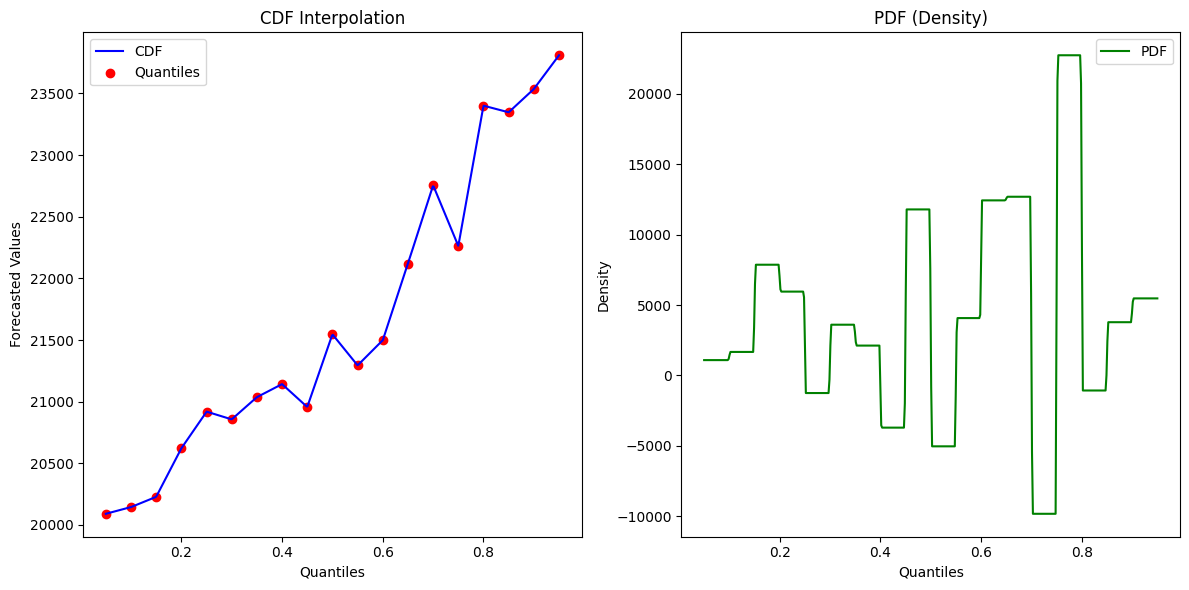

In [26]:
plot_cdf_pdf(lgb_dfs[1], quantiles, number=1)

**CDF (Kumulative Verteilungsfunktion):**

- Funktion: Die CDF zeigt die Wahrscheinlichkeit, dass eine Zufallsvariable einen Wert kleiner oder gleich einem bestimmten Wert annimmt.
- Plot: Der Plot der interpolierten CDF zeigt, wie die kumulierten Wahrscheinlichkeiten in Abhängigkeit von den Vorhersagewerten für die Quantile verteilt sind. Dies gibt eine Vorstellung davon, wie sich die Wahrscheinlichkeiten über die Werte verteilen.

**PDF (Wahrscheinlichkeitsdichtefunktion):**

- Funktion: Die PDF beschreibt die Dichte der Verteilung der Zufallsvariable. Sie zeigt an, wie sich die Wahrscheinlichkeit auf verschiedene Werte verteilt.
- Plot: Der Plot der berechneten PDF zeigt, wie stark verschiedene Werte der Vorhersagen auftreten. Höhere Werte der PDF deuten darauf hin, dass diese Werte wahrscheinlicher sind.


- Problem mit den Plots hier: -> Vorhersagen für höhere Quantile

Höhere Quantile: Ein höheres Quantil (z.B. 90%) repräsentiert Werte, die größer sind als die Werte eines niedrigeren Quantils (z.B. 10%). Das bedeutet, dass die Vorhersage für das 90. Quantil immer größer sein sollte als die Vorhersage für das 10. Quantil. Dies folgt direkt aus der Definition von Quantilen.

Hier ist jedoch die Vorhersage falsch, denn hier gilt:

- 20% der Fälle sind unter 20.000 Fußgängern.
- 30% der Fälle sind unter 18.000 Fußgängern.


Das ist inkonsistent und falsch, da das 30. Perzentil einen höheren Wert als das 20. Perzentil haben sollte. Die Vorhersage für ein höheres Quantil muss immer größer oder gleich der Vorhersage für ein niedrigeres Quantil sein. In diesem Beispiel wäre das ein Vorhersagefehler oder ein Problem mit der Modellierung.


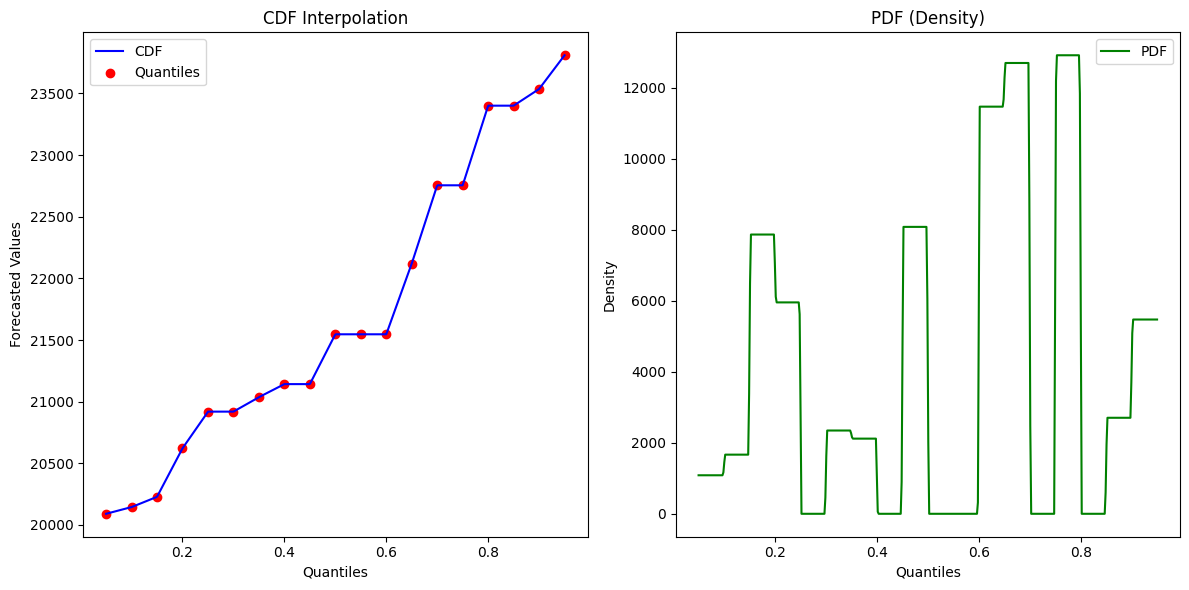

In [27]:
plot_cdf_pdf(post_process_quantiles(lgb_dfs[1]), quantiles, number=2)

-  Nachbearbeitung der Verteilungsvorhersagen, um sicherzustellen, dass die Vorhersagen für höhere Quantile nicht kleiner sind als die für niedrigere Quantile.

Aufgrund dieser Fehler implementiere ich im folgenden Catboost:

In [28]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


### 4. Catboost

In [29]:
from catboost import CatBoostRegressor

quantile_str = str(quantiles).replace('[','').replace(']','')


cat_boost_dfs = {}


for i in range(1, num_test_sets + 1):

    cat_boost_dfs[i] = pd.DataFrame(columns=quantiles)

    df_train = get_train_i(i)
    df_test = get_test_i(i)


    # Use a catboost model with all quantiles
    model = CatBoostRegressor(
        loss_function=f'MultiQuantile:alpha={quantile_str}',
        random_state=42,
        verbose=0
    )

    # Fit the model
    model.fit(df_train[ml_features_list], df_train['pedestrians_count'])

    # Predict the quantiles
    preds = model.predict(df_test[ml_features_list])
    # Save the predictions
    cat_boost_dfs[i] = pd.DataFrame(preds, columns=quantiles)

cat_boost_dfs





{1:            0.05          0.10          0.15          0.20          0.25  \
 0  19491.731946  20378.669749  20752.495561  20900.835379  21005.671486   
 1  22216.690725  22890.579929  23637.372624  24007.387859  24389.691409   
 2   6028.474980   8692.166469  11163.181594  11931.742629  13015.466216   
 3  18224.605844  20021.245642  20324.354687  20400.237937  20581.410776   
 4  22152.112438  22677.491378  23575.063988  24628.476591  25388.118076   
 5   4347.601203   7707.700114  10497.980517  11572.474941  12233.179222   
 
            0.30          0.35          0.40          0.45          0.50  \
 0  21103.685014  21192.930827  21415.211434  21592.210259  21635.077146   
 1  24873.473193  25149.089540  25435.706485  25651.216633  25795.904625   
 2  13549.766869  13726.421946  13995.549564  14286.420400  14460.818049   
 3  20655.007174  20762.266874  20934.720235  20994.994934  21111.626947   
 4  25965.834814  26515.740336  26845.743081  27272.902197  27525.730188   
 5  126

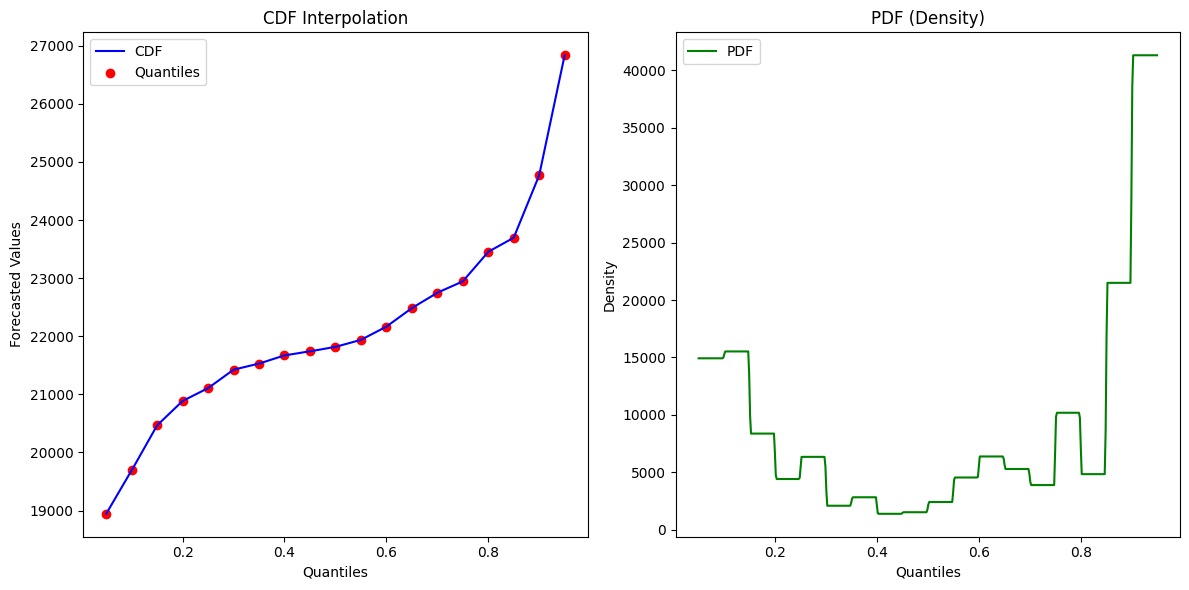

In [30]:
plot_cdf_pdf(cat_boost_dfs[i], quantiles, number=3)

- Hier haben wir nicht mehr den Quantil-Fehler von oben

In [31]:
for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    cat_boost_df = cat_boost_dfs[i]

    mql_cat, mae_cat = evaluate(cat_boost_df, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['CatBoost', i, HORIZON, mql_cat, mae_cat]


eval_df

The multi quantile loss (MQL) is: 810.53
The mean absolute error (MAE) is: 2474.90
The multi quantile loss (MQL) is: 1689.66
The mean absolute error (MAE) is: 4087.32
The multi quantile loss (MQL) is: 789.57
The mean absolute error (MAE) is: 2111.01
The multi quantile loss (MQL) is: 737.44
The mean absolute error (MAE) is: 1879.20
The multi quantile loss (MQL) is: 466.41
The mean absolute error (MAE) is: 1175.03
The multi quantile loss (MQL) is: 784.99
The mean absolute error (MAE) is: 1912.22
The multi quantile loss (MQL) is: 2368.38
The mean absolute error (MAE) is: 5393.11
The multi quantile loss (MQL) is: 981.55
The mean absolute error (MAE) is: 2506.40
The multi quantile loss (MQL) is: 1091.36
The mean absolute error (MAE) is: 2767.82


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


In [32]:
eval_df

,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


## 5. Random Forest

In [33]:
pip install quantile-forest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.0 MB/s eta 0:00:00


In [34]:
from quantile_forest import RandomForestQuantileRegressor
from sklearn import datasets

random_forest_dfs = {}


for i in range(1, num_test_sets + 1):

    random_forest_dfs[i] = pd.DataFrame(columns=quantiles)

    df_train = get_train_i(i)
    df_test = get_test_i(i)


    # Use a catboost model with all quantiles
    model = RandomForestQuantileRegressor(
        #loss_function=f'MultiQuantile:alpha={quantile_str}',
        random_state=42,
        verbose=0
    )

    # Fit the model
    model.fit(df_train[ml_features_list], df_train['pedestrians_count'])

    # Predict the quantiles
    preds = model.predict(df_test[ml_features_list], quantiles)


    # Save the predictions
    random_forest_dfs[i] = pd.DataFrame(preds, columns=quantiles)

random_forest_dfs

{1:        0.05     0.10      0.15     0.20      0.25     0.30     0.35     0.40  \
 0  20013.00  20087.0  20447.25  20884.4  20923.00  20923.0  20923.0  20923.0   
 1  23955.00  23955.0  23955.00  23955.0  23955.00  23957.0  23957.0  24658.6   
 2  11630.00  12405.0  12569.00  12569.0  12569.00  12732.1  12802.0  13740.2   
 3  19554.65  19914.0  20074.00  20087.0  20087.00  20087.0  20162.0  20261.2   
 4  21836.00  22064.0  22064.00  23145.0  23732.25  24447.6  25140.0  25210.0   
 5  11630.00  11630.0  11630.00  11630.0  12569.00  12569.0  12569.0  12569.0   
 
       0.45     0.50      0.55     0.60     0.65     0.70     0.75     0.80  \
 0  20923.0  20923.0  20923.00  20923.0  20923.0  20923.0  22016.0  23495.0   
 1  25348.0  25729.0  25729.00  26696.0  27042.7  27291.0  27291.0  27291.0   
 2  14113.0  14396.0  14797.00  15103.0  15103.0  15103.0  15103.0  15103.0   
 3  20349.0  20732.0  20759.45  20807.0  20807.0  20858.0  20907.0  20913.0   
 4  25210.0  25210.0  25210.00  2

In [35]:
for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    random_forest_df = random_forest_dfs[i]

    mql_rf, mae_rf = evaluate(random_forest_df, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['RandomForest', i, HORIZON, mql_rf, mae_rf]


eval_df

The multi quantile loss (MQL) is: 692.80
The mean absolute error (MAE) is: 1877.50
The multi quantile loss (MQL) is: 1967.26
The mean absolute error (MAE) is: 4985.50
The multi quantile loss (MQL) is: 847.74
The mean absolute error (MAE) is: 2198.33
The multi quantile loss (MQL) is: 604.94
The mean absolute error (MAE) is: 1995.42
The multi quantile loss (MQL) is: 609.56
The mean absolute error (MAE) is: 1449.58
The multi quantile loss (MQL) is: 720.66
The mean absolute error (MAE) is: 1851.92
The multi quantile loss (MQL) is: 2381.51
The mean absolute error (MAE) is: 5124.33
The multi quantile loss (MQL) is: 1020.34
The mean absolute error (MAE) is: 2582.17
The multi quantile loss (MQL) is: 1004.67
The mean absolute error (MAE) is: 2881.42


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


## Get the feature importance of the model  

In [36]:
!pip install shap

Catboost Feature Importance

Light gbm  Feature Importance

In [37]:
# Plot feature importance using shapely
import shap

# Define lgbm model that predicts the median
model = lgb.LGBMRegressor(
            objective='quantile',
            alpha=0.5, # alpha Parameter gibt Quantil an
            random_state=42,
            verbose=-1
        )

# Train on all data
model.fit(df_day[ml_features_list], df_day['pedestrians_count'])

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_day[ml_features_list])

# Calculate the mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'feature': ml_features_list,
    'importance': np.abs(shap_values.values).mean(axis=0)
})

# Sort the features by importance
shap_importance = shap_importance.sort_values(by='importance', ascending=False)

# Display the ordered list of features by importance
print(shap_importance)



                     feature   importance
21  pedestrians_count_7d_lag  4098.833922
5             weekday_Sunday  2035.971820
24    location_Spiegelstraße  1065.627206
23  location_Schönbornstraße   969.649044
4           weekday_Saturday   895.227269
1                   holidays   835.345506
2             weekday_Friday   352.820713
20                  month_12   333.264515
9                    month_1   250.478042
16                   month_8    89.166895
13                   month_5    85.832299
22     location_Kaiserstraße    84.644916
3             weekday_Monday    79.883477
15                   month_7    79.749102
10                   month_2    65.529097
11                   month_3    64.102314
0              special_event    57.395051
14                   month_6    57.061922
19                  month_11    53.762200
18                  month_10    40.998188
7            weekday_Tuesday    34.982249
17                   month_9    29.258821
12                   month_4    25

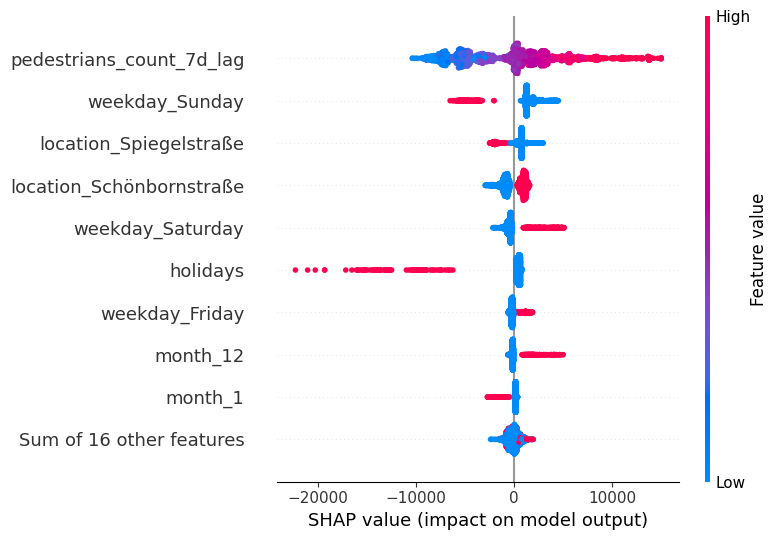

In [38]:
# Plot feature importance using shapely
import shap

# Define lgbm model that predicts the median
model = lgb.LGBMRegressor(
            objective='quantile',
            alpha=0.5, # alpha Parameter gibt Quantil an
            random_state=42,
            verbose=-1
        )

# Train on all data
model.fit(df_day[ml_features_list], df_day['pedestrians_count'])

# Calculate shapley values and ensure it returns an Explanation object
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_day[ml_features_list]) # Call the explainer on the data

# Plot the shapley values using the Explanation object
shap.plots.beeswarm(shap_values, show=False)
# tight layout
plt.tight_layout()
# Save the plot to a file
plt.savefig('/content/drive/My Drive/BA/shap_beeswarm_plot.png')

plt.show()







## 6. Deep Learning: LSTM

In [39]:
pip install NeuralForecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [40]:
import torch
from neuralforecast.auto import  AutoLSTM, AutoMLP, AutoRNN, AutoTiDE
from neuralforecast.models import MLP, LSTM, RNN, TiDE
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast import NeuralForecast

# Konfiguriere das Gerät: Wenn CUDA verfügbar ist, wird es verwendet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definiere Modelle und verschiebe sie auf das GPU-Gerät
levels = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


model_names = ['LSTM']

models = [
    LSTM(input_size=len(futr_exog_list*HORIZON), h=HORIZON,
        futr_exog_list = futr_exog_list,
        stat_exog_list=static_feature_list,
        scaler_type = 'robust',
        loss=MQLoss(level=levels),
        max_steps=200,#500
        learning_rate=0.0035,
        encoder_hidden_size=50,
        decoder_hidden_size=50,
        random_seed=42,
        ).to(device)
]

# Initialisiere das NeuralForecast-Objekt
nf = NeuralForecast(models=models, freq='D')

# Überprüfe, ob die GPU korrekt verwendet wird
print(f"Verwende Gerät: {device}")


INFO:lightning_fabric.utilities.seed:Seed set to 42


Verwende Gerät: cuda


In [41]:
static_df = pd.DataFrame(
      columns=['unique_id', 'location_Kaiserstraße','location_Schönbornstraße','location_Spiegelstraße'],
      data=[['Kaiserstraße', 1, 0, 0 ], ['Schönbornstraße', 0, 1, 0], ['Spiegelstraße', 0, 0, 1]]
  )

static_df

,unique_id,location_Kaiserstraße,location_Schönbornstraße,location_Spiegelstraße
0,Kaiserstraße,1,0,0
1,Schönbornstraße,0,1,0
2,Spiegelstraße,0,0,1


In [42]:
def format_nixta_output(nixta_pred, model_name, hi_or_lo='hi'):

  quantile_pred = nixta_pred.copy()


  quantile_pred.reset_index(drop=False, inplace=True)
  # Sort nixta_pred by date
  quantile_pred.sort_values(by=['ds', 'unique_id'], inplace=True)
  col_names = [f'{model_name}-{hi_or_lo}-{int(100*q)}' for q in quantiles]
  # Get the predictions
  quantile_pred = quantile_pred[col_names]

  # Rename the columns
  quantile_pred.columns = quantiles

  quantile_pred.reset_index(drop=True, inplace=True)

  return quantile_pred


In [43]:

lstm_dfs_lo = {}
lstm_dfs_hi = {}
lstm_dfs = {}

for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    lstm_dfs[i] = pd.DataFrame(columns=quantiles)

    train_df_nixtla = format_dataset_for_nixtla(df_train)
    test_df_nixtla = format_dataset_for_nixtla(df_test)

    nf.fit(df=train_df_nixtla, static_df=static_df)

    quantile_estimates_lstm = nf.predict(futr_df=test_df_nixtla)
    quantile_estimates_lstm.sort_values(by='ds')

    lstm_dfs_hi[i] = format_nixta_output(quantile_estimates_lstm, 'LSTM', hi_or_lo='hi')

<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-12-cb37a504fa55>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


- "lo" steht für die unteren Quantile (niedrigere Vorhersagen).
- "hi" steht für die oberen Quantile (höhere Vorhersagen).

Zum Beispiel:

LSTM-lo-95: Das 5%-Quantil, d.h., es gibt eine 95%ige Wahrscheinlichkeit, dass der wahre Wert über dieser Vorhersage liegt.
LSTM-hi-95: Das 95%-Quantil, d.h., es gibt eine 95%ige Wahrscheinlichkeit, dass der wahre Wert unter dieser Vorhersage liegt.

**-> Ich schaue hi-Quantil an**

In [44]:
for i in range(1, num_test_sets + 1):

    df_train = get_train_i(i)
    df_test = get_test_i(i)

    lstm_df_hi = lstm_dfs_hi[i]

    mql_lstm, mae_lstm = evaluate(lstm_df_hi, horizon=HORIZON, i_test=i)
    eval_df.loc[len(eval_df)] = ['LSTM', i, HORIZON, mql_lstm, mae_lstm]


eval_df

The multi quantile loss (MQL) is: 1221.46
The mean absolute error (MAE) is: 2631.93
The multi quantile loss (MQL) is: 1572.41
The mean absolute error (MAE) is: 3452.21
The multi quantile loss (MQL) is: 907.60
The mean absolute error (MAE) is: 2228.23
The multi quantile loss (MQL) is: 494.80
The mean absolute error (MAE) is: 1235.41
The multi quantile loss (MQL) is: 256.98
The mean absolute error (MAE) is: 798.50
The multi quantile loss (MQL) is: 1800.44
The mean absolute error (MAE) is: 3823.82
The multi quantile loss (MQL) is: 1070.91
The mean absolute error (MAE) is: 2584.52
The multi quantile loss (MQL) is: 2002.78
The mean absolute error (MAE) is: 4225.65
The multi quantile loss (MQL) is: 1354.79
The mean absolute error (MAE) is: 3017.86


,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


In [45]:
eval_df

,Method,Test Set,Horizon,MQL,MAE
0,Empirical Quantiles,1,2,1997.525526,5243.666667
1,Empirical Quantiles,2,2,5328.116491,14422.666667
2,Empirical Quantiles,3,2,2128.681491,5544.500000
3,Empirical Quantiles,4,2,4191.953509,12068.833333
4,Empirical Quantiles,5,2,1728.168509,4534.666667
5,Empirical Quantiles,6,2,2840.435088,8877.333333
6,Empirical Quantiles,7,2,5188.920175,13325.500000
7,Empirical Quantiles,8,2,3196.974912,9197.666667
8,Empirical Quantiles,9,2,1910.133772,4946.166667
9,Quantile Regression,1,2,1910.133772,2324.415546


In [46]:
eval_df.to_csv(f'/content/drive/My Drive/BA/eval_df_tagesdaten_WITHOUT_WEATHER_FORECAST_{SHORT_TIME_OR_LONG_TIME}.csv', index=False)